In [2]:
# for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd
import glob
import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

Make sure to upload your data to Google Drive and mount the drive to make it accessible via your colab notebook. 

Load the time series image. Here, we will be using a tiff stack but trackpy uses PIMS that can handle a variety of formats. 

The test image used here has the following properties:

*   39 frames in 6840 seconds
* 652 x 476 pixel frames
*   0.545 um pixel size
* Fluorescence images collected on Zeiss CD7 microscope




In [3]:
#To read AVI files 
#!conda install av -c conda-forge

#Then use PyAVVideoReader to read AVI images
#my_avi_img = pims.PyAVVideoReader('/content/drive/MyDrive/ColabNotebooks/data/tracking_data/Cell-counting-time-series.avi')

In [4]:
#To read scientific images using Bioformats
#!conda install jpype1 -c conda-forge
#Then read images using Bioformats
#my_zeiss_image = pims.BioformatsReader('/content/drive/MyDrive/ColabNotebooks/data/tracking_data/Cell-counting-time-series.czi')

In [5]:


# # Specify the path to your PNG images. Use a wildcard pattern to match all PNG files.
# image_path = 'test/*.png'

# # List of all PNG files
# image_files = sorted(glob.glob(image_path))

# # Ensure there are images to process
# if not image_files:
#     raise ValueError(f"No images found in path: {image_path}")

# # Open the first image to start the sequence
# first_image = Image.open(image_files[0])

# # Convert images to the same mode as the first image if needed
# frames = [Image.open(img).convert(first_image.mode) for img in image_files[1:]]

# # Save as multi-frame TIFF
# output_path = 'test.tif'
# first_image.save(output_path, save_all=True, append_images=frames, compression="tiff_deflate")

# print(f"Multi-frame TIFF saved to {output_path}")


In [6]:
# To read standard files, including tiff stacks, we can use pims.open
my_fl_img=pims.open('test.tif')

In [7]:
my_fl_img

<Frames>
Source: test.tif
Length: 40 frames
Frame Shape: (1024, 1344, 3)
Pixel Datatype: uint8

In [8]:
my_fl_img.shape #39 images, each 476 x 652

(40, 1024, 1344, 3)

Trackpy offers various ways to segment your images (e.g., tp.locate for blob detection) but we will be using Stardist as it provides a robust deep learning based pre-trained models to segment fluorescence images. You can also train your own models. Please watch my tutorials on this topic. 

In [9]:
from stardist.models import StarDist2D 
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [10]:
# prints a list of available models 
StarDist2D.from_pretrained() 

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [11]:
# Define a pretrained model to segment nuclei in fluorescence images (download from pretrained)
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


(-0.5, 1343.5, 1023.5, -0.5)

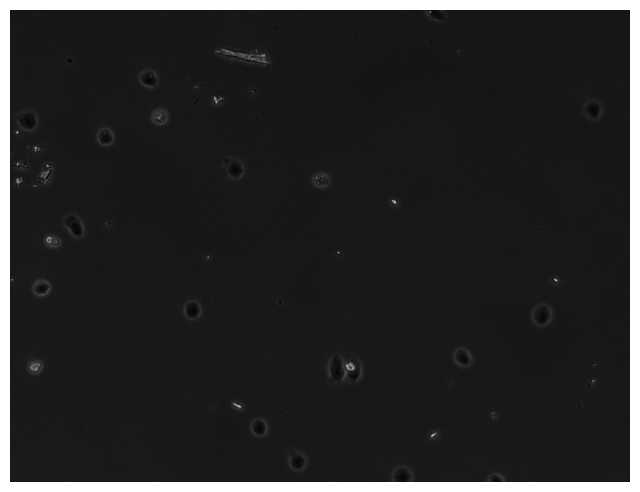

In [12]:
plt.figure(figsize=(8,8))
plt.imshow(my_fl_img[0], cmap='gray')
plt.axis("off")

Define a function for Stardist based segmentation and decorate it with pims.pipeline. This allows us to use the Stardist based segmentation for our timeseries. 

In [13]:
from skimage.color import rgb2gray

@pims.pipeline
def stardist_segm(img):
    # Ensure the image is in grayscale
    if img.ndim == 3 and img.shape[-1] == 3:
        img = rgb2gray(img)
    img_labels, img_details = model.predict_instances(normalize(img))
    return img_labels

Apply the segmentation function to out time series data set. 

In [14]:
label_image = stardist_segm(my_fl_img)

In [15]:
label_image

(TiffStack_tifffile,) processed through proc_func. Original repr:
    <Frames>
    Source: test.tif
    Length: 40 frames
    Frame Shape: (1024, 1344, 3)
    Pixel Datatype: uint8

Plot a few images from our time series along with corresponding segmentation result. 

Number of frames in my_fl_img: 40
Shape of first frame in my_fl_img: (1024, 1344, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


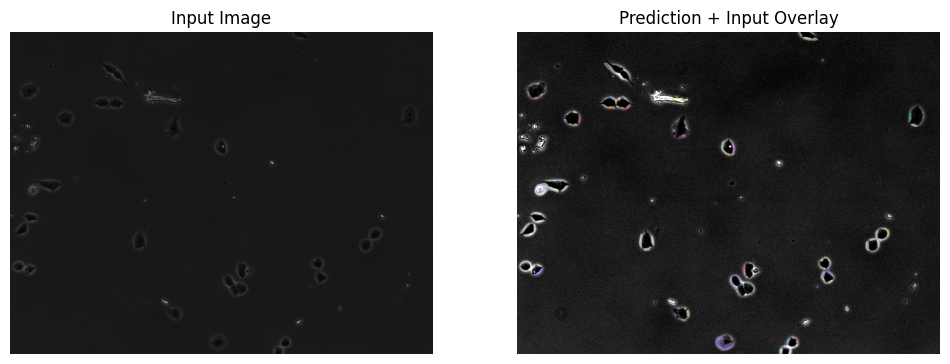

In [16]:

# Check lengths and shapes
print("Number of frames in my_fl_img:", len(my_fl_img))
print("Shape of first frame in my_fl_img:", my_fl_img[0].shape)

# Process a single frame to check for issues
img_num = 16  # Choose an example frame
test_frame = my_fl_img[img_num]

# Perform segmentation on the test frame
label_test_frame = stardist_segm(test_frame)

# Display the input image and the prediction overlay for the test frame
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_frame, cmap="gray")
plt.axis("off")
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(render_label(label_test_frame, img=test_frame))
plt.axis("off")
plt.title("Prediction + Input Overlay")
plt.show()

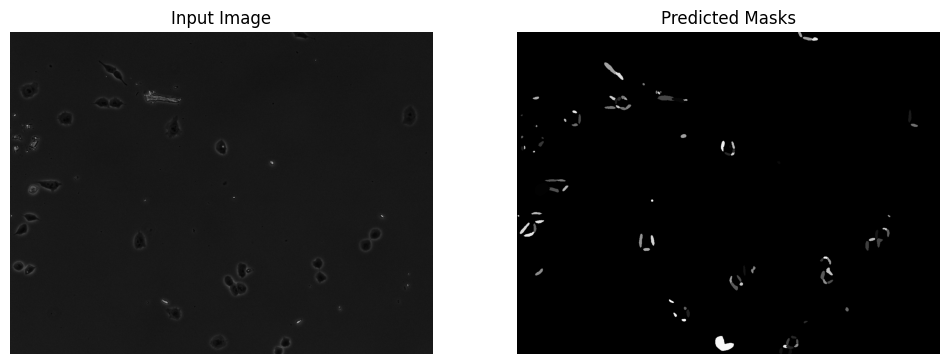

In [18]:
# Display the input image and the prediction (mask) for the test frame
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(test_frame, cmap="gray")
plt.axis("off")
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.imshow(label_test_frame, cmap="gray")
plt.axis("off")
plt.title("Predicted Masks")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

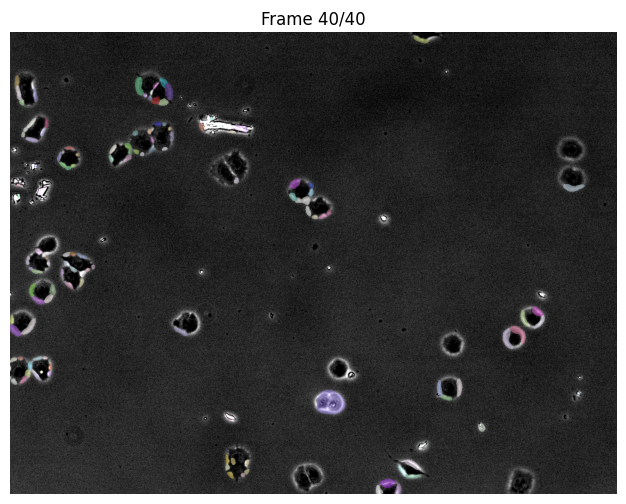

In [17]:
from matplotlib.animation import FuncAnimation

# Define a function to perform segmentation on each frame
def segment_frames(frames):
    segmented_frames = []
    for frame in frames:
        segmented_frame = stardist_segm(frame)
        segmented_frames.append(segmented_frame)
    return segmented_frames

# Segment all frames
segmented_frames = segment_frames(my_fl_img)

# Function to update the animation
def update(frame):
    plt.clf()
    plt.imshow(render_label(segmented_frames[frame], img=my_fl_img[frame]), cmap='gray')
    plt.axis('off')
    plt.title(f'Frame {frame+1}/{len(my_fl_img)}')

# Create animation
fig = plt.figure(figsize=(8, 6))
ani = FuncAnimation(fig, update, frames=len(my_fl_img), interval=500, repeat=True)

# Save the animation as a GIF (optional)
ani.save('segmentation_animation_star.gif', writer='imagemagick')

plt.show(plt.show(block=True))


The segmentation result from Stardist already provides a labeled image. If you are using regular binarization or thresholding, make sure you label the image (e.g., using skimage.meadure.label)

Let us use skimage.measure.regionprops to extract the centroid coordinates for all our objects. 

In [15]:
import skimage

In [16]:

# Initialize a list to collect feature dictionaries
features_list = []

# Iterate through the frames and corresponding label images
for num, img in enumerate(my_fl_img):
    # Ensure the label image is processed correctly
    label_img = label_image[num]
    
    for region in skimage.measure.regionprops(label_img, intensity_image=img):
        # Collect features in a dictionary
        features_dict = {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num,
            'area': region.area,
        }
        # Append the dictionary to the list
        features_list.append(features_dict)

# Convert the list of dictionaries to a DataFrame
features = pd.DataFrame(features_list)

In [17]:
features.head

<bound method NDFrame.head of                y           x  frame   area
0     342.064220  504.477064      0  109.0
1     772.772009   53.632054      0  443.0
2     652.569565  379.391304      0  230.0
3     774.374046  732.213740      0  131.0
4     301.153846   55.288462      0   52.0
...          ...         ...    ...    ...
3984  513.123077   84.630769     39   65.0
3985  362.372093   18.953488     39   43.0
3986  201.675862   80.441379     39  145.0
3987  220.408451  438.154930     39   71.0
3988  637.467105    3.868421     39  152.0

[3989 rows x 4 columns]>

You can use tp.annotate to display the objects that we will be tracking. 

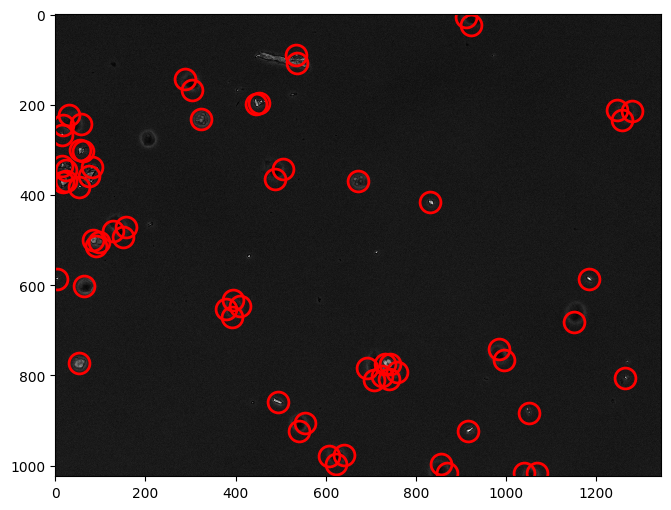

<Axes: >

In [18]:
tp.annotate(features[features.frame==(0)], my_fl_img[0])

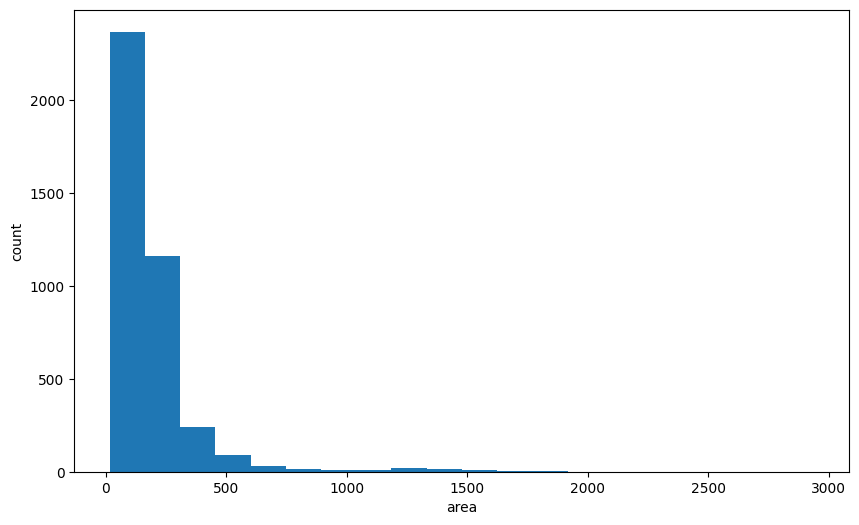

In [19]:
#Plot object areas to investigate the distribution. You can further filter out objects based on size or intensity. Not required in our case.  
fig, ax = plt.subplots()
ax.hist(features['area'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='area', ylabel='count');

We have the locations of the particles in each frame. Next we'll track particles from frame to frame, giving each one a number for identification..
Link a DataFrame of coordinates into trajectories using trackpy.link_df

Uses: Crocker, J.C., Grier, D.G. http://dx.doi.org/10.1006/jcis.1996.0217

In [20]:
#Bubble tracking
# we must must specify a maximum displacement, the farthest a object can travel between frames (search_range)
# We allow for the possibility that an object might be missed for a few frames and then seen again. 
# Memory keeps track of disappeared objects and maintains their ID for up to some number of frames after their last appearance. 
# Here we use 5 frames.
# Note that the term particle refers to an object of interest. 
search_range = 11
t = tp.link_df(features, search_range, memory=5)

# # Ensure 'particle' is not an index level
# if 'particle' in t.index.names:
#     t = t.reset_index()

# # Remove duplicate 'particle' columns if any
# t = t.loc[:, ~t.columns.duplicated()]
# # Check for and resolve any remaining issues with 'particle'
# if 'particle' in t.columns and 'particle' in t.index.names:
#     t = t.reset_index().loc[:, ~t.columns.duplicated()]
t.head()

Frame 39: 146 trajectories present.


,y,x,frame,area,particle
0,342.064220,504.477064,0,109.0,0
35,513.411043,90.196319,0,163.0,1
36,245.918367,17.537415,0,147.0,2
37,882.751634,1049.542484,0,153.0,3
38,198.875000,446.062500,0,64.0,4


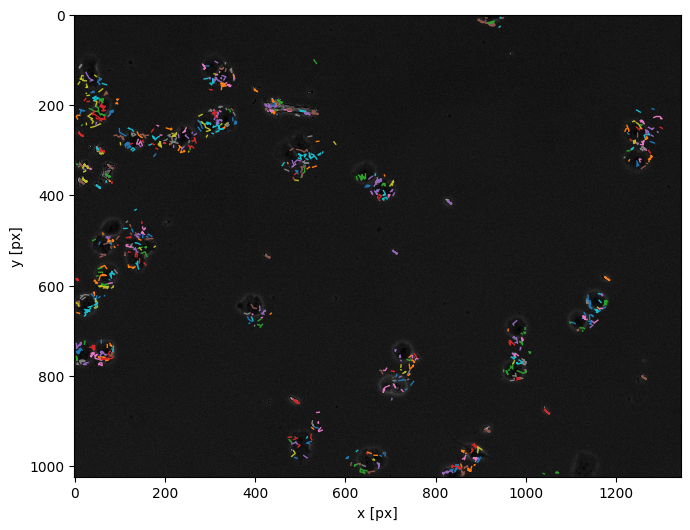

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [21]:
#Plot trajectories
tp.plot_traj(t, superimpose=img) #Remove the superimpose part to just plot the trajectories. 

In [22]:
# Compute and subtract drift
drift = tp.compute_drift(t)

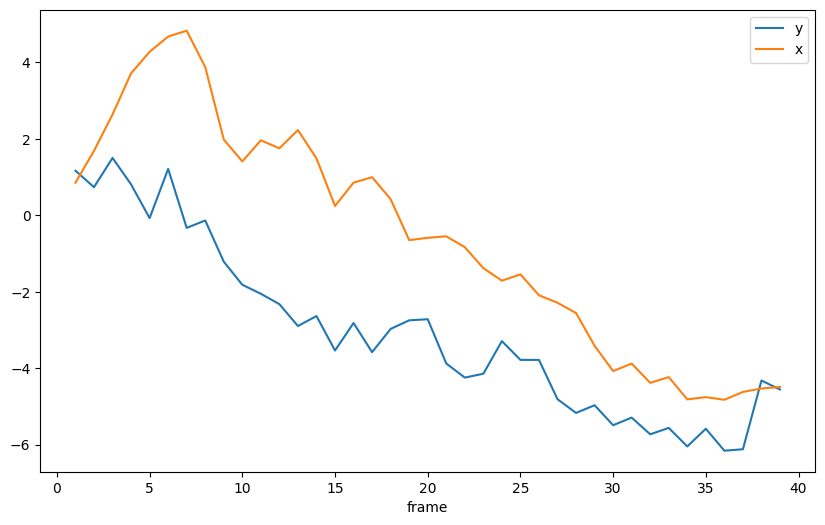

In [23]:
drift.plot()
plt.show()

In [24]:
t_corrected = tp.subtract_drift(t.copy(), drift)

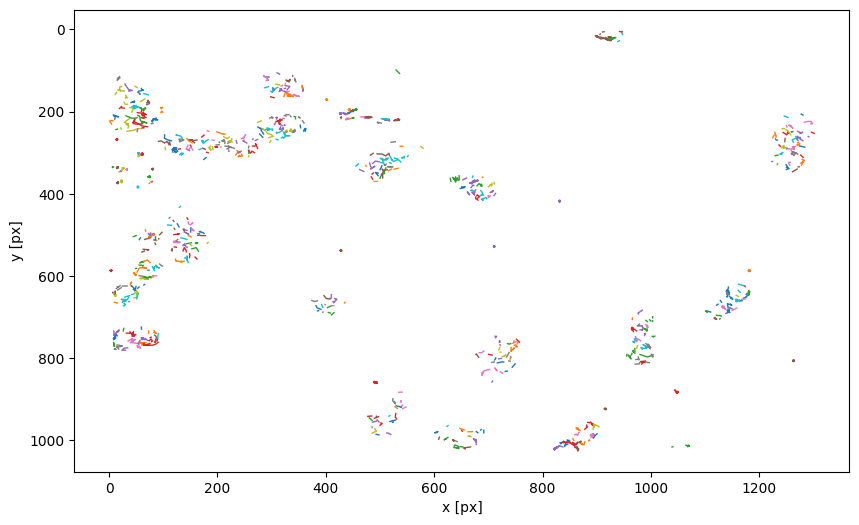

In [25]:
ax = tp.plot_traj(t_corrected)
plt.show()

Plotting velocity fields 

Pivot the dataframe (t) to get objects/particles in column for each row corresponding to a frame. This is to make it easy for us to perform velocity field calculations for each object.

In [26]:
unstacked = t.set_index(['frame', 'particle']).unstack()

In [27]:
unstacked

y                                                  \
particle         0           1           2           3           4     
frame                                                                  
0         342.064220  513.411043  245.918367  882.751634  198.875000   
1                NaN         NaN         NaN  883.431193  201.711111   
2                NaN  514.954839  243.323171         NaN         NaN   
3                NaN  513.419192  245.037736  884.164062  206.878788   
4                NaN         NaN         NaN  883.417323         NaN   
5         341.262899         NaN         NaN  881.770701  204.423729   
6         333.047038         NaN         NaN  884.805085         NaN   
7                NaN         NaN         NaN  882.870690         NaN   
8                NaN  513.086066         NaN         NaN  204.171717   
9                NaN         NaN         NaN         NaN  201.000000   
10               NaN         NaN         NaN  883.008547  202.016949   
11               NaN         NaN         NaN  882.373134         NaN   
12               NaN         NaN         NaN         NaN         NaN   
13               NaN         NaN         NaN  882.048544         NaN   
14               NaN         NaN         NaN         NaN  204.532468   
15               NaN         NaN         NaN  881.536364         NaN   
16               NaN         NaN         NaN  882.128440         NaN   
17               NaN         NaN         NaN  881.304348  202.171053   
18               NaN         NaN         NaN  880.556701  202.222222   
19               NaN         NaN         NaN  880.631068         NaN   
20               NaN         NaN         NaN  875.833333  204.592593   
21               NaN         NaN         NaN  879.866667         NaN   
22               NaN         NaN         NaN  880.160377         NaN   
23               NaN         NaN         NaN         NaN  200.681818   
24               NaN         NaN         NaN         NaN  202.445946   
25               NaN         NaN         NaN         NaN         NaN   
26               NaN         NaN         NaN  873.750000  200.862745   
27               NaN         NaN         NaN  877.755725  199.954023   
28               NaN         NaN         NaN         NaN  201.212766   
29               NaN         NaN         NaN  877.534759  200.986111   
30               NaN         NaN         NaN  878.672414  200.677419   
31               NaN         NaN         NaN  877.932203  200.197368   
32               NaN         NaN         NaN         NaN  198.962963   
33               NaN         NaN         NaN  877.885057  201.098361   
34               NaN         NaN         NaN  877.400000  200.672414   
35               NaN         NaN         NaN  878.202186  201.113208   
36               NaN         NaN         NaN  877.559783  201.686047   
37               NaN         NaN         NaN  875.839827  198.859155   
38               NaN         NaN         NaN  878.004854  201.074074   
39               NaN         NaN         NaN  876.708134  199.215385   

                                                                     ...  \
particle        5           6           7           8           9    ...   
frame                                                                ...   
0         23.303448  471.047887  792.823708  302.552632  976.228283  ...   
1         21.121622         NaN         NaN  307.673913         NaN  ...   
2         20.525641  473.290816         NaN  303.521739         NaN  ...   
3         19.419929  472.011494         NaN  308.619048         NaN  ...   
4         19.699219  476.467236         NaN  308.184211         NaN  ...   
5         18.111888  473.120968         NaN  306.277778         NaN  ...   
6         22.532258  469.954545         NaN         NaN         NaN  ...   
7         24.331915         NaN         NaN         NaN         NaN  ...   
8         23.811404         NaN         NaN  307.806452         NaN  ...   
9         

In [29]:
data = []  # Create an empty list to store dictionaries

for item in set(t.particle):
    sub = t[t.particle==item]
    dvx = np.diff(sub.x)
    dvy = np.diff(sub.y)
    for x, y, dx, dy, frame in zip(sub.x[:-1], sub.y[:-1], dvx, dvy, sub.frame[:-1]):
        data.append({'dx': dx, 
                     'dy': dy, 
                     'x': x,
                     'y': y,
                     'frame': frame,
                     'particle': item
                    })

# Create DataFrame outside the loop
data_df = pd.DataFrame(data)

In [30]:
from matplotlib.pyplot import quiver

Plot the velocity fields. 

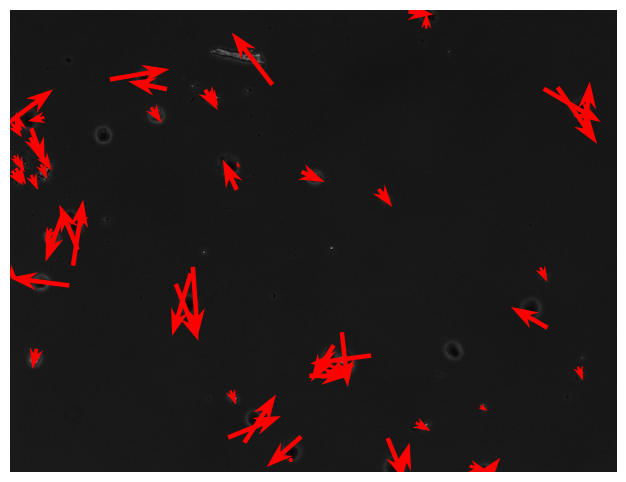

In [32]:

# Assuming 'data' is a list of dictionaries
data_df = pd.DataFrame(data)

i = 0
d = data_df[data_df.frame == i]
plt.imshow(my_fl_img[i])
plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
plt.axis('off')
plt.show()